In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa, os

import numpy as np
import cartopy.crs as ccrs
import networkx as nx

import warnings
from shapely.errors import ShapelyDeprecationWarning
import gurobipy

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))

In [2]:
# load network 2
n2 = pypsa.Network(r"C:\Users\quy43055\Tasks\Task 6\elec_s_300_lv1.35__Co2L0-72H-T-H-B-I-A-solar+p3-dist1_2045.nc")

INFO:pypsa.io:Imported network elec_s_300_lv1.35__Co2L0-72H-T-H-B-I-A-solar+p3-dist1_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
n2.optimize()

KeyError: 'efficiency2'

In [3]:
n2.links.index

Index(['14547', '5686', '14539', '12998', '14562', '14538', '14550', '14537',
       '14563', '14542',
       ...
       'H2 pipeline new NO3 4 <-> SE3 10', 'H2 pipeline new NO3 9 <-> SE3 3',
       'H2 pipeline new SE3 0 <-> SE3 11', 'H2 pipeline new SE3 0 <-> SE3 9',
       'H2 pipeline new SE3 1 <-> SE3 8', 'H2 pipeline new SE3 1 <-> SE3 6',
       'H2 pipeline new SE3 10 <-> SE3 4', 'H2 pipeline new SE3 2 <-> SE3 9',
       'H2 pipeline new SE3 3 <-> SE3 6', 'H2 pipeline new SE3 4 <-> SE3 8'],
      dtype='object', name='Link', length=14553)

In [4]:
n2.lines.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '514', '515', '516', '517', '518', '519', '520', '521', '522', '523'],
      dtype='object', name='Line', length=523)

In [5]:
n2.branch_components

{'Line', 'Link', 'Transformer'}

In [6]:
## calculate the line loading
loading = (n2.lines_t.p0.abs().mean().sort_index() / (n2.lines.s_nom_opt*n2.lines.s_max_pu).sort_index()).fillna(0.)

In [7]:
#n2.lines_t.p0.abs().mean().sort_index()
#n2.lines.s_nom_opt
#n2.lines.s_max_pu

In [8]:
## PlateCarree, Mercator, Orthographic: here are some projections of the map, can be changed according to preferences

(-1020040.5776197813,
 2853505.4697317737,
 -437748.4731467446,
 7787038.391846162)

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


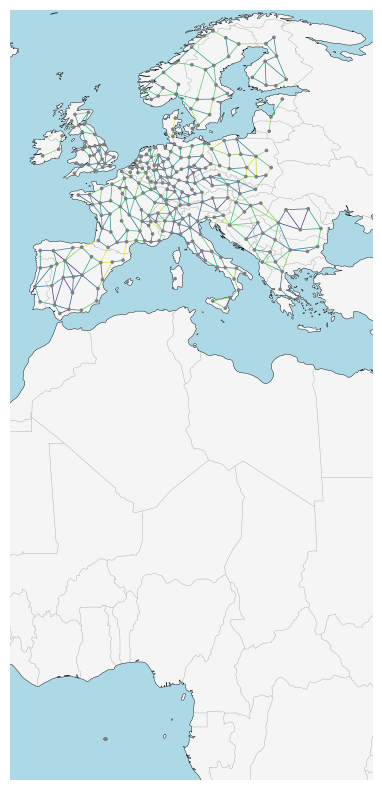

In [9]:
### then display the line loads (without loads: line_widths left out)
fig,ax = plt.subplots(
            figsize=(10,10),
            subplot_kw={"projection": ccrs.EqualEarth()}
        )

n2.plot(ax=ax,
      bus_colors='gray',
      branch_components=["Line"],
      #line_widths=n2.lines.s_nom_opt/3e3,
      line_widths=0.5,
      line_colors=loading,
      line_cmap=plt.cm.viridis,
      color_geomap=True,
      bus_sizes=0.05)

ax.axis('off')

In [10]:
lines = n2.lines.sort_values('s_nom', ascending=False)#.query("carrier=='H2 pipeline'")

In [52]:
h2_links = n2.links.query("carrier=='H2 pipeline'")

In [92]:
#h2_production = n2.links_t.p1["electrolysis"].div(1e3)
#h2_consumption = n2.links_t.p0["fuel cell link"].div(1e3)


In [53]:
# h2 pipelines capacity
h2_pip = round(n2.links_t.p0.filter(like='H2 pipeline').sum().div(1e9)*(365*24),2) # thousand TWh
h2_pip


Link
H2 pipeline AL0 0 -> IT0 12        -0.33
H2 pipeline AT0 0 -> DE0 0         -0.01
H2 pipeline AT0 1 -> AT0 2         -0.01
H2 pipeline AT0 1 -> AT0 3         -2.07
H2 pipeline AT0 1 <-> AT0 2        -0.50
                                    ... 
H2 pipeline new SE3 1 <-> SE3 6    -0.90
H2 pipeline new SE3 10 <-> SE3 4   -0.34
H2 pipeline new SE3 2 <-> SE3 9    -0.56
H2 pipeline new SE3 3 <-> SE3 6    -0.10
H2 pipeline new SE3 4 <-> SE3 8    -0.43
Length: 701, dtype: float64

In [56]:
H = nx.from_pandas_edgelist(h2_links, 'bus0', 'bus1', edge_attr=["p_max_pu", "p_nom"])
#H = nx.from_pandas_edgelist(h2_pip, 'bus0', 'bus1', edge_attr=["p0"])


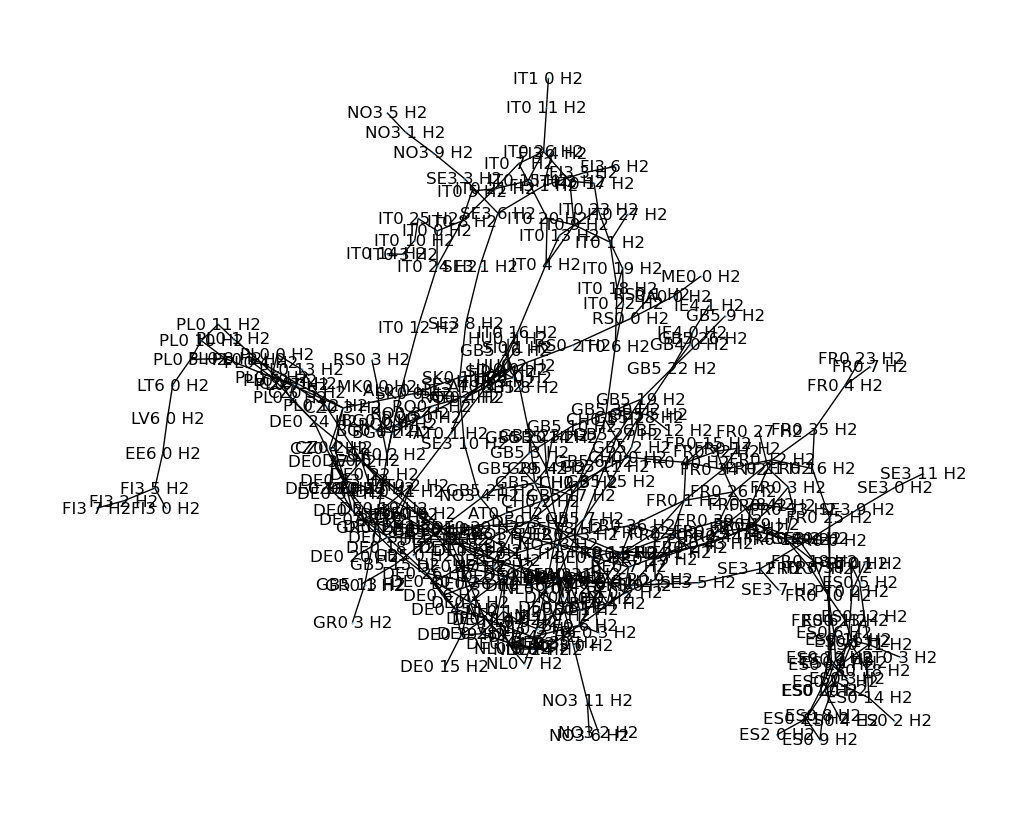

In [57]:
# H2 nodes from network 2
nx.draw(H, with_labels=True, node_size=0.1)

In [58]:
p_max_pu = nx.get_edge_attributes(H, 'p_max_pu').values()
b = [1/p for p in p_max_pu]
B = np.diag(b)

In [59]:
K = nx.incidence_matrix(H).todense()


In [60]:
I = B.dot(K.T)

In [61]:
L = K.dot(I)

In [62]:
L_inv = np.linalg.pinv(L)

In [63]:
PTDF = I.dot(L_inv)

In [64]:
imbalance = np.zeros(len(H.nodes))
imbalance[0] = 1
imbalance[-1] = -1

In [65]:
flows= PTDF.dot(imbalance)

In [66]:
abs_flows = np.abs(flows)

NetworkXError: Node 'AL0 0 H2' has no position.

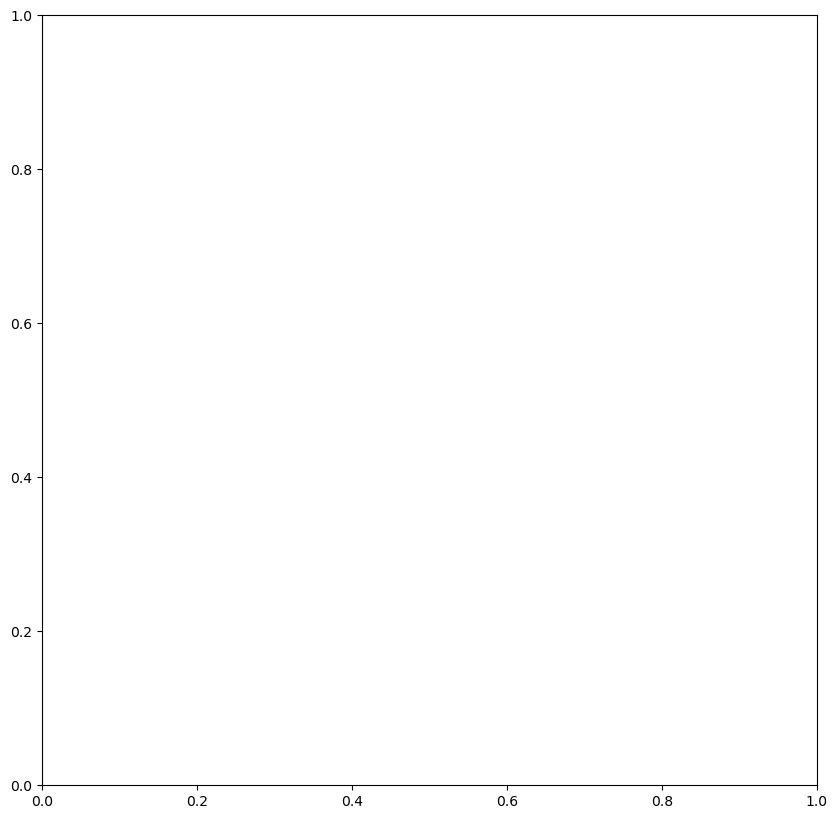

In [70]:
nodes = h2_links.bus0

#pos = nodes.apply(tuple, axis=1).to_dict()
pos = nodes.apply(lambda x: tuple(x)).to_dict()
sub_pos = {k: v for k, v in pos.items() if k in H.nodes}
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(H, pos=sub_pos, node_size = 0.2, edge_color='gray', width=2)

In [75]:
# get mean generator by bus and carrier 
gen = n2.generators.assign(g=n2.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()*(365*24) # MWh
#gen.filter(like='H2', axis=0)
gen.to_frame().reset_index(level='carrier')

,carrier,g
bus,,
AL0 0,offwind-ac,5.275625e-02
AL0 0,onwind,1.620059e-01
AL0 0,solar,4.548585e+07
AL0 0,solar rooftop,5.973629e-01
AL0 0 residential rural heat,residential rural solar thermal,4.593382e-01
...,...,...
SK0 1 residential rural heat,residential rural solar thermal,1.207105e-01
SK0 1 residential urban decentral heat,residential urban decentral solar thermal,1.402038e-01
SK0 1 services rural heat,services rural solar thermal,1.208857e-01


In [76]:
gen2 = gen.sort_values()

In [77]:
flow = pd.Series(10, index=n2.branches().index).sort_index()#.name#.loc['H2 pipelines'] # set arbitary values as 10
flow.to_frame().index.nlevels # check index levels of the dataframe -> this df has multi index

2

In [78]:
flow_df = flow.to_frame()
flow_df1 = flow_df.reset_index(level='name') # reset df to single index

In [86]:
flow_df1#.filter(like='H2', axis=1)#.groupby(by='name', axis=0)

,name,0
component,,
Line,1,10
Line,10,10
Line,100,10
Line,101,10
Line,102,10
...,...,...
Link,gas for industry,10
Link,gas for industry CC,10
Link,process emissions,10


In [40]:
#flow.to_csv('flow')

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


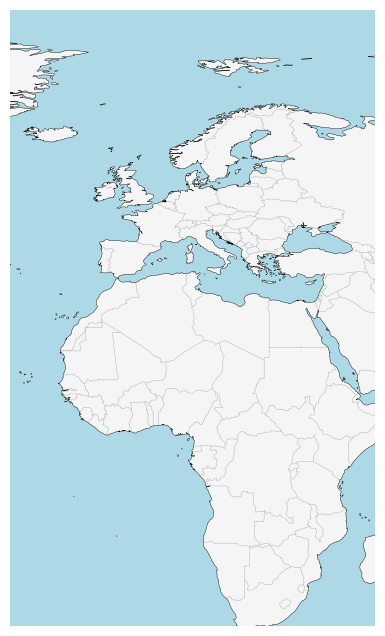

In [37]:
# plot the electricity flow

n2.plot(
    bus_sizes=gen2 / 5e3,
    bus_colors='darkgreen',
    margin=0.5,
    flow='mean',
    line_widths=0.1,
    link_widths=0.1,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
)
plt.show()

(-1020040.5776197813,
 2853505.4697317737,
 -437748.4731467446,
 7787038.391846162)

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


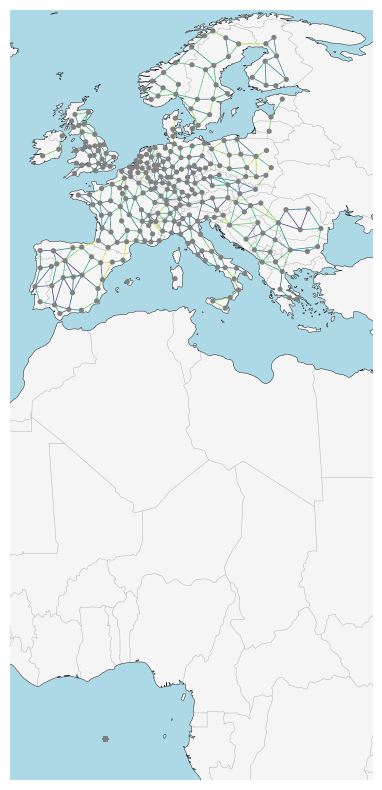

In [120]:
fig,ax = plt.subplots(
            figsize=(10,10),
            subplot_kw={"projection": ccrs.EqualEarth()}
        )

n2.plot(ax=ax,
      bus_colors='gray',
      branch_components=["Line"],
      flow=flow,
      line_widths=0.5,
      line_colors=loading,
      line_cmap=plt.cm.viridis,
      color_geomap=True,
      bus_sizes=0.1)

ax.axis('off')

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


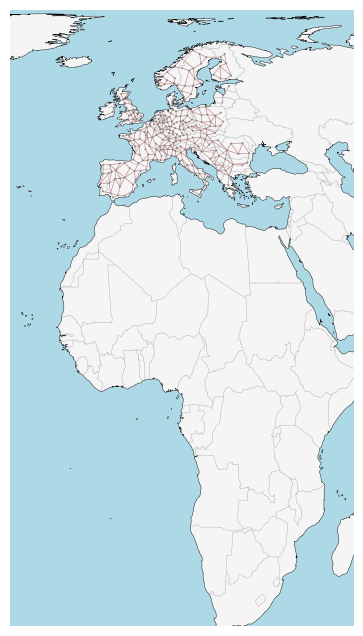

In [148]:
# plot the electricity flow

n2.plot(
    bus_sizes=0.05,
    bus_colors='gray',
    margin=0.5,
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()

In [121]:
coords = pypsa.plot.autogenerate_coordinates(n2, assign=False, layouter=None)
coords.sort_index()

,x,y
AL0 0,-0.193312,0.089988
AL0 0 EV battery,-0.991101,-0.128924
AL0 0 H2,-0.091895,-0.011584
AL0 0 battery,-0.577703,0.311197
AL0 0 home battery,-0.996703,0.074144
...,...,...
co2 atmosphere,0.248726,0.003044
co2 stored,0.248668,0.248815
gas for industry,-0.093680,-0.098192
process emissions,0.194227,-0.236612


In [123]:
coords_H2 = coords.filter(like='H2', axis=0)

In [152]:
coords1 = coords.rename(columns= {"x":"x1"})

In [111]:
N = nx.from_pandas_edgelist(lines, 'bus0', 'bus1', edge_attr=["x_pu", "s_nom"])
N

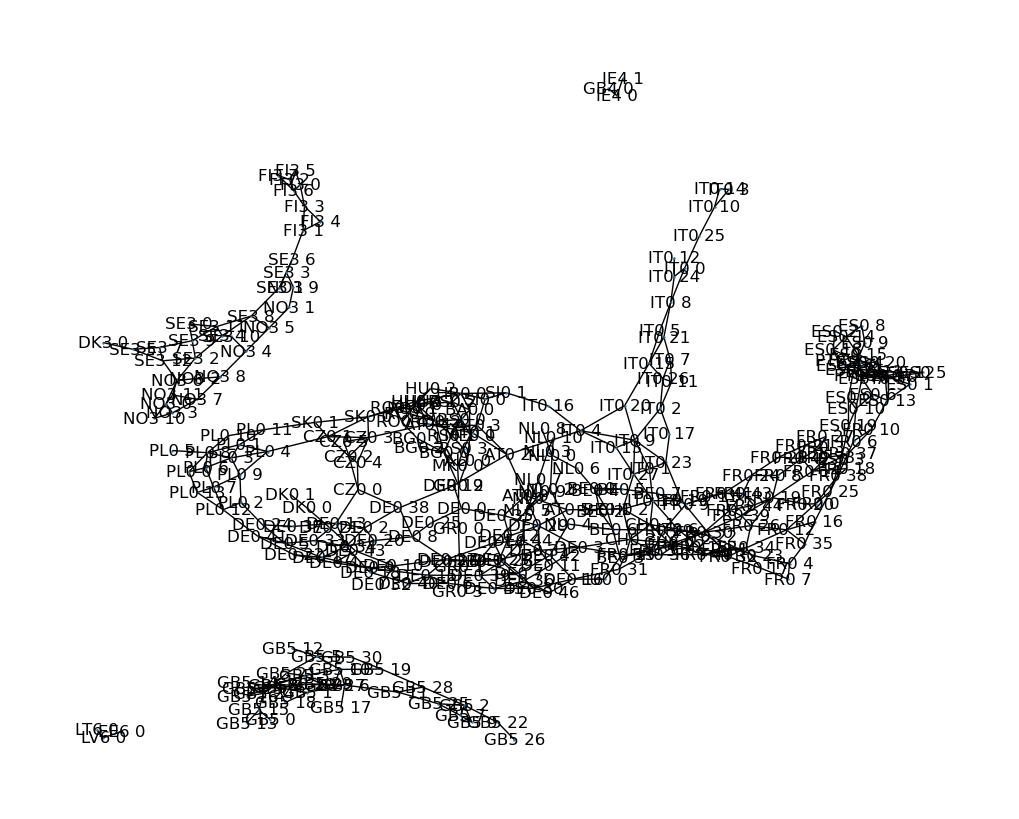

In [176]:
nx.draw(N, with_labels=True, node_size=0.5)

In [117]:
len(list(nx.connected_components(N)))

5

In [46]:
coords.loc['EU H2']

x    0.603897
y    0.240848
Name: EU H2, dtype: float64

In [48]:
coords.filter(like='H2 pipeline')

""
AL0 0
AT0 0
AT0 1
AT0 2
AT0 3
...
SI0 0 home battery
SI0 1 home battery
SK0 0 home battery
SK0 1 home battery


In [58]:
gen(networkx.Graph())

TypeError: 'Series' object is not callable

In [64]:
n2.carriers.color['H2']

''

(<matplotlib.collections.PatchCollection at 0x1d23f7ec640>,
 <matplotlib.collections.PatchCollection at 0x1d23cb2e170>)

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


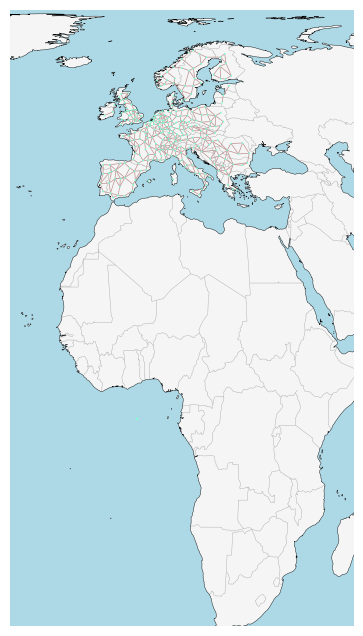

In [124]:
# plot buses and lines
pypsa.plot.plot(n2, margin=0.5, bus_sizes=0.05,
    bus_colors='aquamarine',
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)

In [125]:
pypsa.plot.directed_flow(coords_H2, flow, color='black', area_factor=1, cmap=None, alpha=1)

AttributeError: 'DataFrame' object has no attribute 'x1'

In [144]:
# add legend for lines and links
pypsa.plot.add_legend_lines(with_labels=True)

TypeError: add_legend_lines() got an unexpected keyword argument 'with_labels'

(<matplotlib.collections.PatchCollection at 0x242f0b1eda0>,
 <matplotlib.collections.LineCollection at 0x242897269e0>)

c:\Users\quy43055\.conda\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


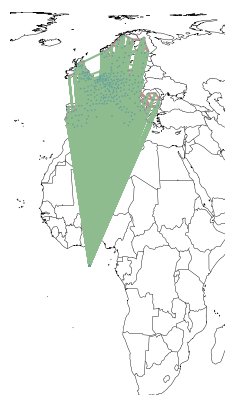

In [65]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.EqualEarth())

n2.plot(ax=ax, margin=0.5, bus_sizes=0.1)